# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

# Data Loading

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz



--2022-05-12 09:30:15--  https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.box.com (sussex.box.com)... 107.152.26.197
Connecting to sussex.box.com (sussex.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-12 09:30:15--  https://sussex.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-12 09:30:16--  https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 107.152.26.201
Connecting to sussex.app.box.com (sussex.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [2]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'f313a54fc57a1235e6307d176fc5fc83fd7ec530')
confirm_checksum('test_images.npz', '4b9efd8eb3b87c07d9c5400ef2494d476bc318a3')
confirm_checksum('examples.npz', 'bf51ebbf42f17e3cbe06bb299746565c53d16c40')

# Load the data

In [3]:
import numpy as np


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

#test images
test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

#example images
example_data = np.load('examples.npz', allow_pickle=True)
example_image = example_data['images']
print(example_image.shape)

(2811, 244, 244, 3) (2811, 42, 2)
(554, 244, 244, 3)
(6, 244, 244, 3)


#Packages

In [4]:
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dense, Dropout, Flatten, RandomFlip, RandomRotation, RandomContrast, Rescaling, Resizing
from tensorflow.keras.models import Sequential 

# Data Visualisation
Here's an example of how to display the images and their points

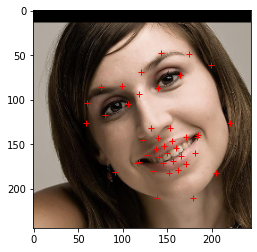

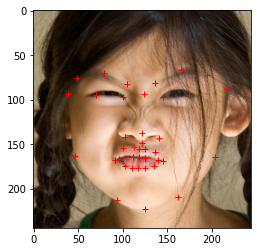

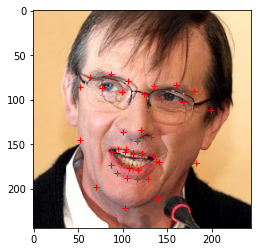

In [5]:
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

# Calculating Prediction Error and exporting results

In [6]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [58]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


#Training Model

In [24]:
#Model 1  

model = Sequential()

#First Convolution layer 
model.add(Conv2D(16,input_shape=(244, 244, 3), kernel_size = (5, 5), activation = 'relu'))
#Second Convolution layer 
model.add(Conv2D(16, kernel_size = (5, 5), activation = 'relu'))
#Maxpool layer size (5,5) 
model.add(MaxPooling2D(pool_size = (5, 5)))
#16 neurons
model.add(Dense(16, activation='relu'))
#Normalises the layers 
model.add(BatchNormalization())

#Third Convolution layer 
model.add(Conv2D(32, kernel_size = (4, 4), activation = 'relu'))
#Fourth Convolution layer 
model.add(Conv2D(32, kernel_size = (4, 4), activation = 'relu'))
#Maxpool layer size (2,2) 
model.add(MaxPooling2D(pool_size=(2, 2)))
#32 neurons
model.add(Dense(32, activation='relu'))
#Normalises the layers 
model.add(BatchNormalization())

#Fifth Convolution layer 
model.add(Conv2D(64, kernel_size = (2, 2), activation = 'relu'))
#Sixth Convolution layer 
model.add(Conv2D(64, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#64 neurons
model.add(Dense(64, activation='relu'))
#Normalises the layers 
model.add(BatchNormalization())

#Seventh Convolution layer 
model.add(Conv2D(128, kernel_size = (2, 2), activation = 'relu'))
#Eighth Convolution layer 
model.add(Conv2D(128, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#128 neurons
model.add(Dense(128, activation='relu'))
#Normalises the layers 
model.add(BatchNormalization())

#Ninth Convolution layer
model.add(Conv2D(84, kernel_size = (2, 2), activation = 'relu'))
#Tenth Convolution layer
model.add(Conv2D(84, kernel_size = (2, 2), activation = 'relu'))
#Dropout with a probablity of 0.3
model.add(Dropout(0.3))
#Flatten changes to dimension 1D
model.add(Flatten())
#84 neurons
model.add(Dense(84, activation='relu'))


model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [40]:
#Model 2 

model = Sequential()

#First Convolution layer
model.add(Conv2D(48, input_shape=(244, 244, 3), kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size = (2, 2)))
#Normalises the layers 
model.add(BatchNormalization())

#Second Convolution layer
model.add(Conv2D(56, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#Normalises the layers 
model.add(BatchNormalization())

#Third Convolution layer
model.add(Conv2D(64, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#Normalises the layers 
model.add(BatchNormalization())

#Fourth Convolution layer
model.add(Conv2D(84, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout with a probablity of 0.2
model.add(Dropout(0.2))
#Flatten changes to dimension 1D
model.add(Flatten())
#84 neurons
model.add(Dense(84, activation='relu'))


model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [48]:
#Data augmentation 
data_augmentation = Sequential([      
       RandomContrast(0.3, input_shape=(244, 244, 3)),
       #Resizing(55,55),
       #Rescaling(1./150),
       #RandomRotation(0.25),
       #RandomFlip(),
                    
])

In [49]:
#Model 3 

model = Sequential()

#First Convolution layer
model.add(Conv2D(48, input_shape=(244, 244, 3), kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size = (2, 2)))
#Normalises the layers 
model.add(BatchNormalization())

#Second Convolution layer
model.add(Conv2D(56, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#Normalises the layers 
model.add(BatchNormalization())

#Third Convolution layer
model.add(Conv2D(64, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#Normalises the layers 
model.add(BatchNormalization())

#Fourth Convolution layer
model.add(Conv2D(84, kernel_size = (2, 2), activation = 'relu'))
#Maxpool layer size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout with a probablity of 0.2
model.add(Dropout(0.2))
#Flatten changes to dimension 1D
model.add(Flatten())
#84 neurons
model.add(Dense(84, activation='relu'))


model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [50]:
#Reshape the pts to match the column of 84. From (2811, 42, 2) to (2811, 84)
reshaped_pts = pts
print(reshaped_pts.shape)

reshaped_pts = reshaped_pts.reshape((2811, 84))
print(reshaped_pts.shape)

(2811, 42, 2)
(2811, 84)


In [ ]:
#Summary of the Model
model.summary()

#Training Model

In [51]:
#Training the model
training = model.fit(images, reshaped_pts, epochs=120, batch_size=45, validation_split=0.3)

Epoch 1/120
44/44 [==============================] - 6s 114ms/step - loss: 2456.0435 - accuracy: 0.5302 - val_loss: 1839.0862 - val_accuracy: 0.7986
Epoch 2/120
44/44 [==============================] - 5s 108ms/step - loss: 112.0925 - accuracy: 0.7911 - val_loss: 1600.7653 - val_accuracy: 0.7986
Epoch 3/120
44/44 [==============================] - 5s 109ms/step - loss: 91.2426 - accuracy: 0.7911 - val_loss: 1109.6105 - val_accuracy: 0.7986
Epoch 4/120
44/44 [==============================] - 5s 109ms/step - loss: 78.7659 - accuracy: 0.7941 - val_loss: 664.3718 - val_accuracy: 0.7986
Epoch 5/120
44/44 [==============================] - 5s 109ms/step - loss: 69.0532 - accuracy: 0.7936 - val_loss: 331.7755 - val_accuracy: 0.8033
Epoch 6/120
44/44 [==============================] - 5s 109ms/step - loss: 62.2868 - accuracy: 0.8104 - val_loss: 208.2333 - val_accuracy: 0.8033
Epoch 7/120
44/44 [==============================] - 5s 109ms/step - loss: 55.3679 - accuracy: 0.8200 - val_loss: 108.

#Average Euclidean Distance on Trained Images

In [52]:
#Reshape the images pts from (2811,84) to (2811, 42, 2) and display the test image with the points plotted

pred_training = model.predict(np.array((images)))
print(pred_training.shape)

pred_training = pred_training.reshape((2811, 42, 2))
print(pred_training.shape)

(2811, 84)
(2811, 42, 2)


In [53]:
#Calculate the average Euclidean distance  
average_euclidDist = np.zeros(pts.shape[0])

for i in range(pts.shape[0]):
  average_euclidDist[i] = np.mean(euclid_dist(pred_training[i],pts[i]))
average_euclidDist = np.mean(average_euclidDist)

print(round(average_euclidDist,4))

3.2371


#Training Results

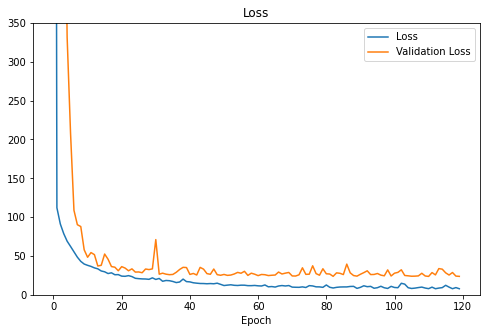

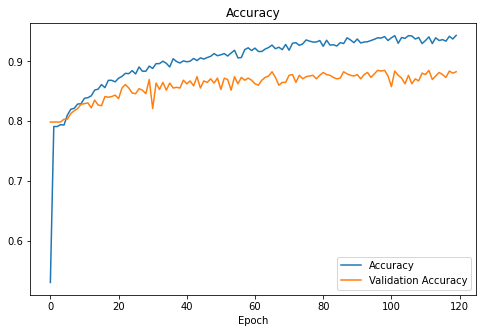

In [54]:
#Plotting the data on graphs 
keys=training.history.keys()

plt.figure(figsize=(8, 5))
plt.ylim(0, 350)
plt.plot(training.history["loss"])
plt.plot(training.history["val_loss"])
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend(["Loss", "Validation Loss"], loc = 'upper right')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(training.history["accuracy"])
plt.plot(training.history["val_accuracy"])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Accuracy", "Validation Accuracy"], loc = 'lower right')
plt.show()

In [55]:
#To calculate the average accuaracy and loss 
acc = np.mean(training.history['accuracy'])
loss = np.mean(training.history['loss'])
val_acc = np.mean(training.history['val_accuracy'])
val_loss = np.mean(training.history['val_loss'])

roundAcc = round(acc,4)
roundLoss = round(loss,4)
roundVal_acc = round(val_acc,4)
roundVal_loss  = round(val_loss,4)

accMesseage = "Average Accuracy:"
lossMessage = "Average Loss:"
Val_accMesseage = "Average Validation Accuracy:"
Val_lossMessage = "Average Validation Loss:"

print(accMesseage, roundAcc)
print(lossMessage, roundLoss)
print(Val_accMesseage, roundVal_acc)
print(Val_lossMessage, roundVal_loss)


Average Accuracy: 0.9024
Average Loss: 38.7028
Average Validation Accuracy: 0.8609
Average Validation Loss: 78.1456


#Plot points on Test Images

(554, 84)
(554, 42, 2)


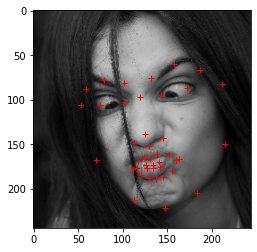

In [59]:
#Reshape the images pts from (554,84) to (554, 42, 2) and display the test image with the points plotted
pred_test = model.predict(np.array((test_images)))

print(pred_test.shape)
pred_test = pred_test.reshape((554, 42, 2))
print(pred_test.shape)

idx = 1

visualise_pts(test_images[idx], pred_test[idx])

#Save as CSV


In [60]:
save_as_csv(pred_test, '/content/drive/My Drive/Computer Vision/Assignment')

#Plot points on example images

(6, 84)
(6, 42, 2)


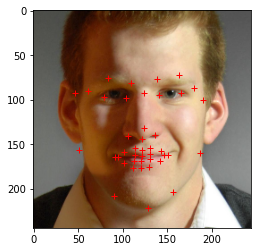

In [66]:
#Reshape the images pts from (6,84) to (554, 42, 2)
pred = model.predict(np.array((example_image)))

print(pred.shape)
pred = pred.reshape((6, 42, 2))

print(pred.shape)

idx = 5
visualise_pts(example_image[idx], pred[idx])

#Lips Colour

In [67]:
#Reshape the points from (6, 84) to (6, 42, 2)
pred = model.predict(np.array((example_image)))
print(pred.shape)

pred_arr = np.array(pred)
pred_arr = np.reshape(pred_arr, (6,-1,2))
print(pred_arr.shape)

(6, 84)
(6, 42, 2)


In [68]:
#Store the points of the lips in array and zip the x and y cordinates 
lips_pts = []
lips = range(22,42)
for element in pred_arr:
  lips_pts.append(list(zip(element[lips,0], element[lips,1])))
  
print(lips_pts)
lips_pt = np.array(lips_pts)

[[(102.25152, 172.2872), (112.84428, 166.6506), (122.39545, 163.58398), (129.9191, 163.96939), (137.8218, 161.7434), (149.10025, 162.05734), (162.1526, 164.10425), (151.07236, 172.2278), (140.4697, 175.31136), (132.36444, 176.78346), (124.56686, 177.42876), (114.50505, 177.23424), (107.63444, 172.49843), (123.40049, 171.428), (130.59328, 170.60938), (137.82498, 168.8088), (156.83316, 164.516), (139.16704, 166.80882), (131.07779, 168.41441), (123.405304, 169.00917)], [(71.168304, 168.98982), (85.57345, 169.80048), (97.92096, 171.1829), (105.27549, 175.75615), (115.17452, 174.89952), (126.69294, 180.28362), (138.84425, 184.31035), (122.35913, 195.37822), (108.16242, 199.03575), (97.7505, 196.82462), (89.33423, 193.542), (79.325424, 185.55782), (75.94669, 171.55592), (94.936844, 179.25725), (103.43941, 182.58922), (113.11688, 183.10854), (133.75826, 183.75435), (111.459724, 185.43173), (101.46918, 184.449), (93.74096, 181.36314)], [(90.87543, 170.4159), (100.185715, 161.53996), (111.98668

In [69]:
examples_copy_lips = np.copy(example_image)

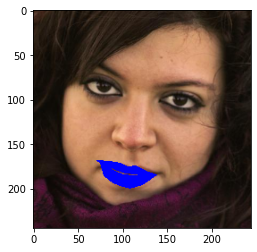

In [91]:
#Display the example images with coloured lips
test_image = 1
tmplips = np.reshape(lips_pt, (6,1,20,2))# 20 points on the lips so needs to be reshaped from (6, 42, 2) to (6,1,20,2)
display_image = cv.fillPoly(examples_copy_lips[test_image], np.int32(tmplips[test_image]), (0,0,255))# Colour blue for the lips

plt.imshow(display_image)

#Eye Colour

In [92]:
#Reshape the points from (6, 84) to (6, 42, 2)
pred = model.predict(np.array((example_image)))
print(pred.shape)

pred_arr = np.array(pred)
pred_arr = np.reshape(pred_arr, (6,-1,2))
print(pred_arr.shape)

(6, 84)
(6, 42, 2)


In [93]:
#Store the points of the eyes in array and zip the x and y cordinates 
lefteye_pts = []
lefteye = [18,19]
righteye_pts = []
righteye = [20,21]

for element in pred_arr:
  lefteye_pts.append(list(zip(element[lefteye,0], element[lefteye,1])))
  righteye_pts.append(list(zip(element[righteye,0], element[righteye,1])))
  
print(lefteye_pts)
print(righteye_pts)

left_eye_pt = np.array(lefteye_pts)
right_eye_pt = np.array(righteye_pts)

[[(76.654045, 102.1527), (103.39049, 100.7016)], [(63.522686, 81.36895), (97.25717, 95.51385)], [(69.00082, 96.373726), (98.44487, 97.36662)], [(78.454834, 99.13771), (108.02511, 97.744225)], [(69.25815, 97.55043), (102.19195, 97.24698)], [(78.47898, 96.40734), (103.27645, 97.34458)]]
[[(143.78096, 93.7697), (169.57727, 88.996)], [(146.70995, 105.81518), (181.29163, 109.05361)], [(145.3694, 96.52511), (176.45844, 95.0875)], [(142.2572, 93.57162), (168.93974, 93.745865)], [(148.18599, 96.121735), (178.76834, 95.34822)], [(140.22429, 94.533455), (165.1425, 92.76826)]]


In [94]:
examples_copy_eyes = np.copy(example_image)

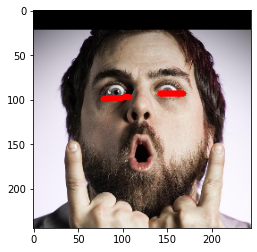

In [96]:
test_image = 3

tmplefteye = np.reshape(left_eye_pt, (6,1,2,2))#Two left eye points, reshape from (6, 42, 2) to (6,1,2,2)
tmprighteye = np.reshape(right_eye_pt, (6,1,2,2))#Two rigth eye points, reshape from (6, 42, 2) to (6,1,2,2)
test = cv.polylines(examples_copy_eyes[test_image], np.int32(tmplefteye[test_image]),1, (255,0,0), thickness=5)#Colour red for the left eye
test = cv.polylines(examples_copy_eyes[test_image], np.int32(tmprighteye[test_image]),1, (255,0,0), thickness=5)#Colour red for the right eye
plt.imshow(test)

#Eyes and Lips colour together 

In [97]:
examples_copy_eyes_lips = np.copy(example_image)

In [98]:
#Store the points of the lips and eyes in array and zip the x and y cordinates 
lefteye_pts = []
lefteye = [18,19]
righteye_pts = []
righteye = [20,21]
lips_pts = []
lips = range(22,42)

for element in pred_arr:
  lips_pts.append(list(zip(element[lips,0], element[lips,1])))
  lefteye_pts.append(list(zip(element[lefteye,0], element[lefteye,1])))
  righteye_pts.append(list(zip(element[righteye,0], element[righteye,1])))

print(lips_pts)  
print(lefteye_pts)
print(righteye_pts)

left_eye_pt = np.array(lefteye_pts)
right_eye_pt = np.array(righteye_pts)

[[(102.25152, 172.2872), (112.84428, 166.6506), (122.39545, 163.58398), (129.9191, 163.96939), (137.8218, 161.7434), (149.10025, 162.05734), (162.1526, 164.10425), (151.07236, 172.2278), (140.4697, 175.31136), (132.36444, 176.78346), (124.56686, 177.42876), (114.50505, 177.23424), (107.63444, 172.49843), (123.40049, 171.428), (130.59328, 170.60938), (137.82498, 168.8088), (156.83316, 164.516), (139.16704, 166.80882), (131.07779, 168.41441), (123.405304, 169.00917)], [(71.168304, 168.98982), (85.57345, 169.80048), (97.92096, 171.1829), (105.27549, 175.75615), (115.17452, 174.89952), (126.69294, 180.28362), (138.84425, 184.31035), (122.35913, 195.37822), (108.16242, 199.03575), (97.7505, 196.82462), (89.33423, 193.542), (79.325424, 185.55782), (75.94669, 171.55592), (94.936844, 179.25725), (103.43941, 182.58922), (113.11688, 183.10854), (133.75826, 183.75435), (111.459724, 185.43173), (101.46918, 184.449), (93.74096, 181.36314)], [(90.87543, 170.4159), (100.185715, 161.53996), (111.98668

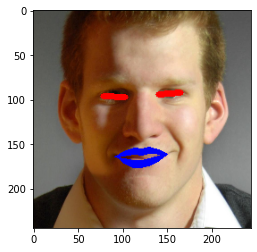

In [101]:
test_image = 5

tmplips = np.reshape(lips_pt, (6,1,20,2)) #20 points on the lips so needs to be reshaped from (6, 42, 2) to (6,1,20,2)
tmplefteye = np.reshape(left_eye_pt, (6,1,2,2)) #Two left eye points, reshape from (6, 42, 2) to (6,1,2,2))
tmprighteye = np.reshape(right_eye_pt, (6,1,2,2))#Two right eye points, reshape from (6, 42, 2) to (6,1,2,2))
test = cv.fillPoly(examples_copy_eyes_lips[test_image], np.int32(tmplips[test_image]), (0,0,255))#Colour blue for the lips
test = cv.polylines(examples_copy_eyes_lips[test_image], np.int32(tmplefteye[test_image]),1, (255,0,0), thickness=5)#Colour red for the left eye
test = cv.polylines(examples_copy_eyes_lips[test_image], np.int32(tmprighteye[test_image]),1, (255,0,0), thickness=5)#Colour red for the right eye
plt.imshow(test)